## 2.3 Deep Exploratory Data Analysis 


Loading raw data...

Filtering timestamps outside reasonable range (2000-2022)...
Timestamps out of range: 2756101

Converting timestamp to datetime...
Timestamps not converted (NaT): 2756101

Converting data types to optimize memory...

Saving processed data to ../data/processed/events.parquet...
Data saved.

Creating session_id by combining visitorid and hour...

Checking for exposures ('view' or 'impression') in events...

Aggregating exposures...
Aggregating clicks...
Aggregating purchases...
Merging exposures, clicks, and purchases...

Sample of reconstructed exposure-click-purchase data:
    session_id  itemid  exposure_count  click_count  purchase_count
0        0_NaT   67045               1          0.0             0.0
1        0_NaT  285930               1          0.0             0.0
2        0_NaT  357564               1          0.0             0.0
3  1000000_NaT   92951               1          0.0             0.0
4  1000001_NaT   67707               1          0.0       

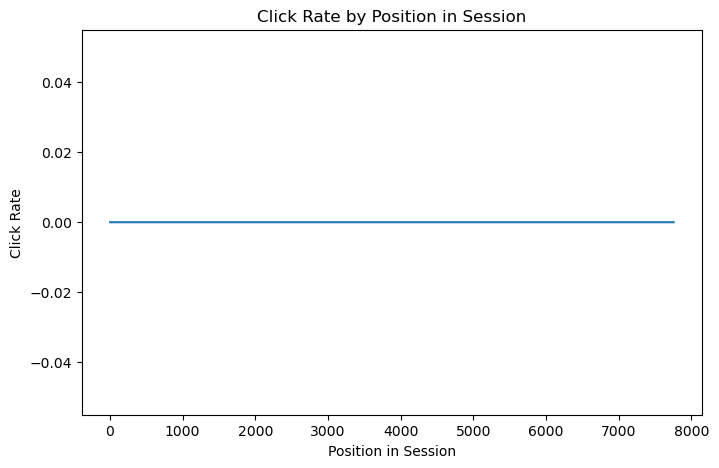


Calculating sparsity and cold-start statistics...
User-Item interaction matrix sparsity: 1.0000
Plotting distribution of interactions per user and per item...


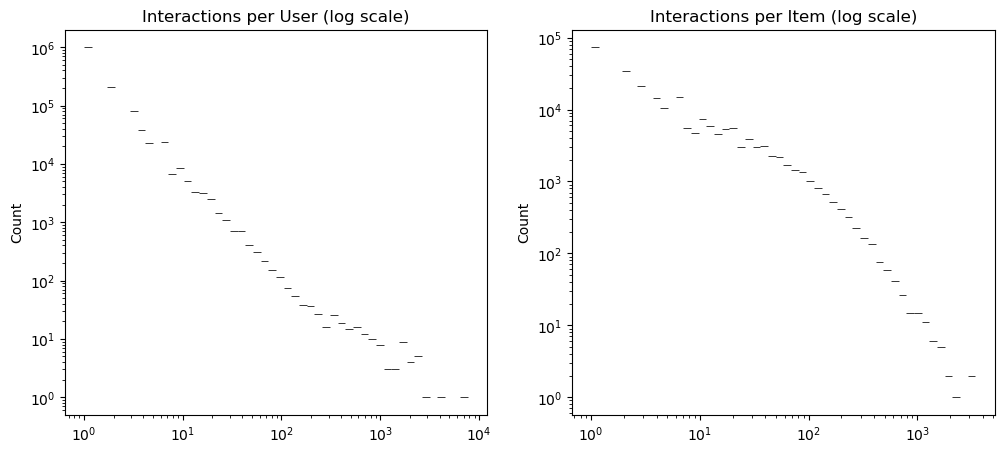

Cold-start users (<5 interactions): 1325960 (94.20%)
Cold-start items (<5 interactions): 144113 (61.31%)

Analyzing session length distribution...


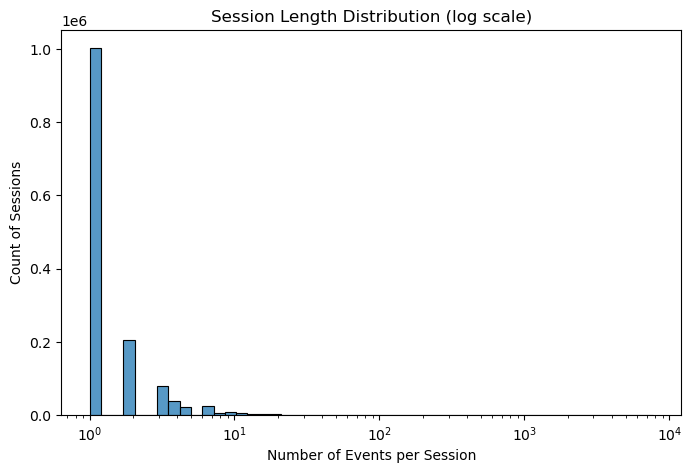

Median session length: 1.0
Session lengths saved to ../data/processed/session_lengths.csv

Analyzing temporal trends in data...


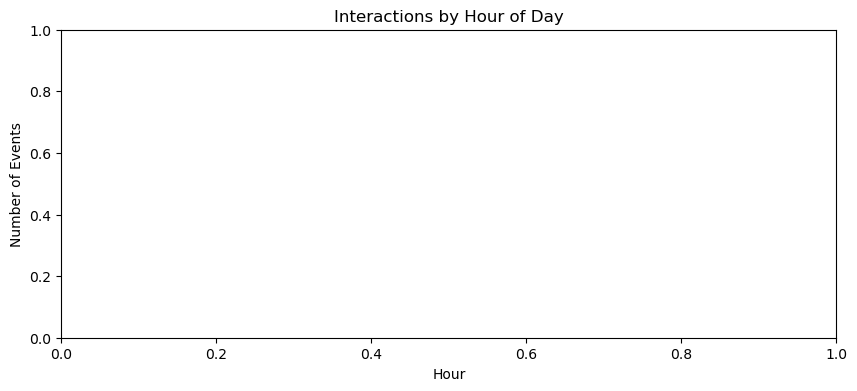

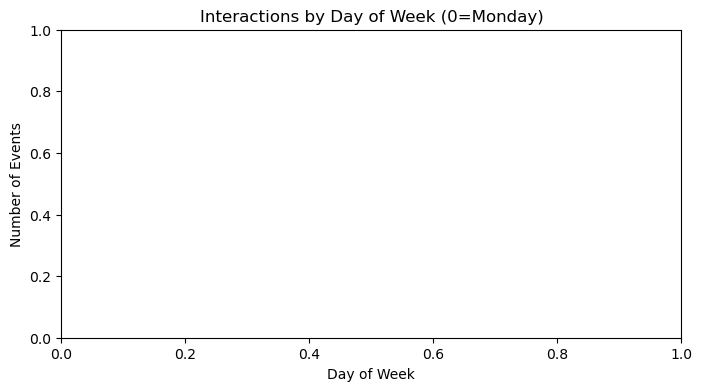

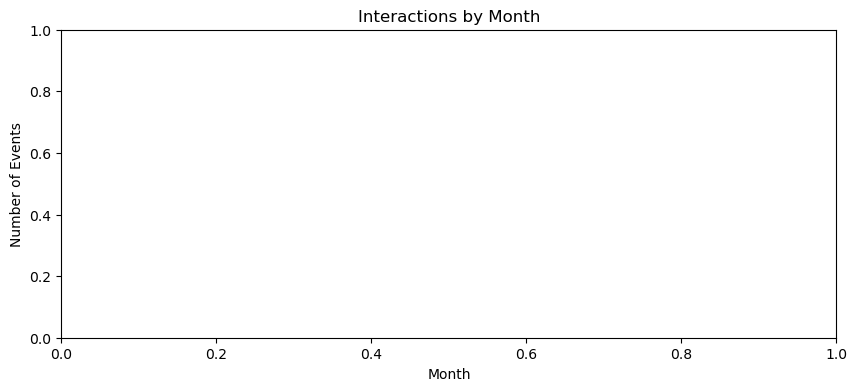


Checking item properties coverage...
Item properties shape: (20275902, 4)

Top properties count:
property
888           3000398
790           1790516
available     1503639
categoryid     788214
6              631471
               ...   
782                 1
288                 1
722                 1
744                 1
769                 1
Name: count, Length: 1104, dtype: int64


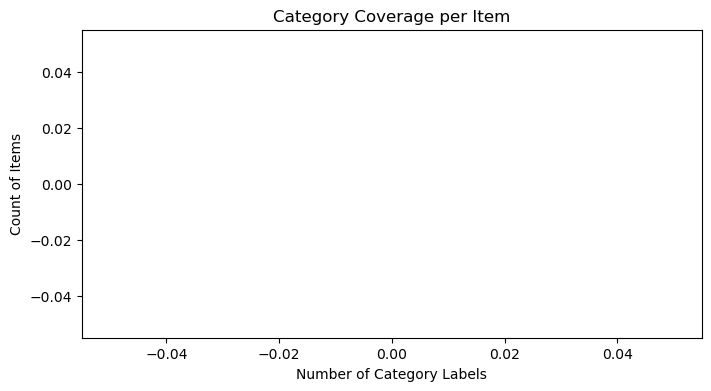

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data(raw_path="../data/raw/retailrocket_events.csv.gz", processed_path="../data/processed/events.parquet"):
    print("\nLoading raw data...")
    df = pd.read_csv(raw_path, compression='gzip')
    
    print("\nFiltering timestamps outside reasonable range (2000-2022)...")
    min_ts = 946684800  # Jan 1, 2000
    max_ts = 1672531199 # Dec 31, 2022
    out_of_range = ((df['timestamp'] < min_ts) | (df['timestamp'] > max_ts)).sum()
    print(f"Timestamps out of range: {out_of_range}")

    df.loc[(df['timestamp'] < min_ts) | (df['timestamp'] > max_ts), 'timestamp'] = np.nan

    print("\nConverting timestamp to datetime...")
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    missing_dates = df['datetime'].isna().sum()
    print(f"Timestamps not converted (NaT): {missing_dates}")

    print("\nConverting data types to optimize memory...")
    df['visitorid'] = df['visitorid'].astype('int32')
    df['itemid'] = df['itemid'].astype('int32')
    df['event'] = df['event'].astype('category')

    print(f"\nSaving processed data to {processed_path}...")
    df.to_parquet(processed_path, index=False)
    print("Data saved.")
    return df

def reconstruct_exposures_clicks_purchases(df):
    print("\nCreating session_id by combining visitorid and hour...")
    df['session_id'] = df['visitorid'].astype(str) + "_" + df['datetime'].dt.floor('h').astype(str)

    print("\nChecking for exposures ('view' or 'impression') in events...")
    if not any(ev in df['event'].unique() for ev in ['view', 'impression']):
        print("No explicit exposures found; cannot reconstruct exposures.")
        return None

    print("\nAggregating exposures...")
    exposures = df[df['event'].isin(['view', 'impression'])].groupby(['session_id', 'itemid']).size().reset_index(name='exposure_count')

    print("Aggregating clicks...")
    clicks = df[df['event'] == 'click'].groupby(['session_id', 'itemid']).size().reset_index(name='click_count')

    print("Aggregating purchases...")
    purchases = df[df['event'] == 'transaction'].groupby(['session_id', 'itemid']).size().reset_index(name='purchase_count')

    print("Merging exposures, clicks, and purchases...")
    df_exp_click = exposures.merge(clicks, how='left', on=['session_id', 'itemid']).fillna(0)
    df_exp_click_purchase = df_exp_click.merge(purchases, how='left', on=['session_id', 'itemid']).fillna(0)

    print("\nSample of reconstructed exposure-click-purchase data:")
    print(df_exp_click_purchase.head())

    output_path = "../data/processed/reconstructed_events.parquet"
    print(f"\nSaving reconstructed data to {output_path}...")
    df_exp_click_purchase.to_parquet(output_path, index=False)
    print("Data saved.")
    return df_exp_click_purchase

def position_bias(df):
    print("\nCalculating click rate by position in session...")
    df_sorted = df.sort_values(['session_id', 'timestamp'])
    df_sorted['position'] = df_sorted.groupby('session_id').cumcount() + 1

    clicks_by_pos = df_sorted.groupby('position')['event'].agg(lambda x: (x == 'click').mean()).reset_index(name='click_rate')

    print("Plotting click rate by position...")
    plt.figure(figsize=(8,5))
    sns.lineplot(data=clicks_by_pos, x='position', y='click_rate')
    plt.title("Click Rate by Position in Session")
    plt.xlabel("Position in Session")
    plt.ylabel("Click Rate")
    plt.show()

def sparsity_and_cold_start(df):
    print("\nCalculating sparsity and cold-start statistics...")
    n_users = df['visitorid'].nunique()
    n_items = df['itemid'].nunique()
    n_interactions = df.shape[0]

    sparsity = 1 - (n_interactions / (n_users * n_items))
    print(f"User-Item interaction matrix sparsity: {sparsity:.4f}")

    user_interactions = df.groupby('visitorid').size()
    item_interactions = df.groupby('itemid').size()

    print("Plotting distribution of interactions per user and per item...")
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(user_interactions, bins=50, log_scale=(True, True))
    plt.title("Interactions per User (log scale)")

    plt.subplot(1,2,2)
    sns.histplot(item_interactions, bins=50, log_scale=(True, True))
    plt.title("Interactions per Item (log scale)")
    plt.show()

    cold_users = (user_interactions < 5).sum()
    cold_items = (item_interactions < 5).sum()

    print(f"Cold-start users (<5 interactions): {cold_users} ({cold_users/n_users:.2%})")
    print(f"Cold-start items (<5 interactions): {cold_items} ({cold_items/n_items:.2%})")

def session_length_distribution(df):
    print("\nAnalyzing session length distribution...")
    session_lengths = df.groupby('session_id').size()

    plt.figure(figsize=(8,5))
    sns.histplot(session_lengths, bins=50, log_scale=True)
    plt.title("Session Length Distribution (log scale)")
    plt.xlabel("Number of Events per Session")
    plt.ylabel("Count of Sessions")
    plt.show()

    median_session_length = session_lengths.median()
    print(f"Median session length: {median_session_length}")

    output_path = "../data/processed/session_lengths.csv"
    session_lengths.to_csv(output_path, index=False)
    print(f"Session lengths saved to {output_path}")

def temporal_trends(df):
    print("\nAnalyzing temporal trends in data...")

    df['hour'] = df['datetime'].dt.hour
    hourly_counts = df.groupby('hour').size()
    plt.figure(figsize=(10,4))
    sns.lineplot(x=hourly_counts.index, y=hourly_counts.values)
    plt.title("Interactions by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Number of Events")
    plt.show()

    df['dayofweek'] = df['datetime'].dt.dayofweek
    dow_counts = df.groupby('dayofweek').size()
    plt.figure(figsize=(8,4))
    sns.barplot(x=dow_counts.index, y=dow_counts.values)
    plt.title("Interactions by Day of Week (0=Monday)")
    plt.xlabel("Day of Week")
    plt.ylabel("Number of Events")
    plt.show()

    df['month'] = df['datetime'].dt.month
    monthly_counts = df.groupby('month').size()
    plt.figure(figsize=(10,4))
    sns.lineplot(x=monthly_counts.index, y=monthly_counts.values)
    plt.title("Interactions by Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Events")
    plt.show()

def metadata_coverage():
    print("\nChecking item properties coverage...")
    item_props_1 = pd.read_csv("../data/raw/item_properties_part1.csv")
    item_props_2 = pd.read_csv("../data/raw/item_properties_part2.csv")
    item_props = pd.concat([item_props_1, item_props_2])

    print(f"Item properties shape: {item_props.shape}")
    print("\nTop properties count:")
    print(item_props['property'].value_counts())

    category_coverage = item_props[item_props['property'] == 'category'].groupby('itemid').size()

    plt.figure(figsize=(8,4))
    sns.histplot(category_coverage, bins=30)
    plt.title("Category Coverage per Item")
    plt.xlabel("Number of Category Labels")
    plt.ylabel("Count of Items")
    plt.show()

if __name__ == "__main__":
    df = prepare_data()
    reconstructed = reconstruct_exposures_clicks_purchases(df)
    position_bias(df)
    sparsity_and_cold_start(df)
    session_length_distribution(df)
    temporal_trends(df)
    metadata_coverage()
